In [1]:
import numpy as np
import xray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import xgcm

In [3]:
iter0 = 2419200
delta_iter = 345600
deltaT = 900
iters_trend = [iter0-delta_iter, iter0]

#ddir = '/data/scratch/rpa/channel_moc/GCM/run_Kr_8e5'
#ddir = '/data/scratch/rpa/channel_moc/GCM/run_K4_1e8'
ddir = '/data/scratch/rpa/channel_moc/GCM/run'
ds = xgcm.open_mdsdataset(ddir, [iter0], deltaT=deltaT,
            prefix=['DiagLAYERS-diapycnal','DiagLAYERS-transport'])
gcm = xgcm.GCMDataset(ds)
ds_trend = xgcm.open_mdsdataset(ddir, iters_trend, deltaT=deltaT,
                prefix=['DiagLAYERS-trend'])

/home/rpa/xgcm/xgcm/mdsxray.py:272: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [4]:
ds

<xray.Dataset>
Dimensions:              (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layers1TH_bounds: 43, layers1TH_center: 42, layers1TH_interface: 41, time: 1)
Coordinates:
    YC                   (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG                   (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA                   (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
  * Xp1                  (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
    PHrefC               (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 ...
    PHrefF               (Zp1) >f4 0.0 98.1 196.2 294.3 412.02 549.36 706.32 ...
    dxG                  (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    dxC                  (Y, Xp1) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Yp1                  (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
  * Zp1                  (

In [5]:
ds_trend

<xray.Dataset>
Dimensions:              (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layers1TH_bounds: 43, layers1TH_center: 42, layers1TH_interface: 41, time: 2)
Coordinates:
    YC                   (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG                   (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA                   (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
  * Xp1                  (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
    PHrefC               (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 ...
    PHrefF               (Zp1) >f4 0.0 98.1 196.2 294.3 412.02 549.36 706.32 ...
    dxG                  (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    dxC                  (Y, Xp1) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Yp1                  (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
  * Zp1                  (

In [5]:
import dask.array as da

# some functions for taking divergence of layers variables
def pad_array(gcm, array, fill_value=(0.,0.),
                    dim='layers1TH_interface', newdim='layers1TH_bounds'):
    """Pad an array on both sides with a fill value.

    Parameters
    ----------
    gcm : xgcm GCMDataset
        A parent object (should be replaced with self once merged into xgcm)
    array : xray DataArray
        The array to difference. Must have the coordinate ``dim``.
    fill_value : tuple, optional
        The values to be used for padding. If ``None``, no pad is applied.
    dim : str, optional
        The variable name for the along which to pad
    newdim : str, optional
        The variable name for the zp1 point

    Returns
    -------
    padded : xray DataArray
        Padded array with vertical coordinate zp1.
    """
    coords, dims = gcm._get_coords_from_dims(array.dims)
    coords_left = coords.copy()
    coords_right = coords.copy()
    idim = dims.index(dim)
    # shape of the new array to concat at the bottom
    shape = list(array.shape)
    shape[idim] = 1
    # replace Zl with the bottom level
    coords_left[dim] = np.atleast_1d(gcm.ds[newdim][0].data)
    coords_right[dim] = np.atleast_1d(gcm.ds[newdim][-1].data)
    
    # an array of zeros at the bottom
    # need different behavior for numpy vs dask
    if array.chunks:
        chunks = list(array.data.chunks)
        chunks[idim] = (1,)
    else:
        chunks = None
    if fill_value[0] is not None:
        if chunks:
            fill_data = da.full(shape, fill_value[0], dtype=array.dtype, chunks=chunks)
        else:
            fill_data = np.full(shape, fill_value[0], array.dtype)
        pad_left = xray.DataArray(fill_data, coords_left, dims)
    if fill_value[1] is not None:
        if chunks:
            fill_data = da.full(shape, fill_value[1], dtype=array.dtype, chunks=chunks)
        else:
            fill_data = np.full(shape, fill_value[1], array.dtype)
        pad_right = xray.DataArray(fill_data, coords_right, dims)        

    # drop unnecessary coordinates from array
    array = array.reset_coords(drop=True)
    
    to_concat = []
    if fill_value[0] is not None:
        to_concat.append(pad_left)
    to_concat.append(array)
    if fill_value[1] is not None:
        to_concat.append(pad_right)
    
    newarray = xray.concat(to_concat, dim=dim, coords='minimal').rename({dim: newdim})
    if newarray.chunks:
        # this assumes that there was only one chunk to begin with
        # how can we do that better
        return newarray.chunk({newdim: len(newarray[newdim])})
    else:
        return newarray

def diff_centered(gcm, array, dim='layers1TH_bounds', newdim='layers1TH_center'):
    """Take the vertical difference of an array located at points dim, resulting
    in a new array at z points.

    Parameters
    ----------
    array : xray DataArray
        The array to difference. Must have the coordinate zp1.
    dim : str, optional
        The variable name along which to difference
    newdim : str, optional
        The new variable name of the resulting calculation

    Returns
    -------
    diff : xray DataArray
        A new array at newdim.
    """
    
    # length of dimension goes down by one after difference
    assert (ds.dims[dim] - ds.dims[newdim])==1, 'Dimensions are not compatible'
    
    a_up = array.isel(**{dim: slice(None,-1)})
    a_dn = array.isel(**{dim: slice(1,None)})
    a_diff = a_up.data - a_dn.data
    # dimensions and coords of new array
    coords, dims = gcm._get_coords_from_dims(array.dims, replace={dim:newdim})
    return xray.DataArray(a_diff, coords, dims)    

def interp_centered(gcm, array, dim='layers1TH_bounds', newdim='layers1TH_center'):
    """Take the vertical average of an array located at points dim, resulting
    in a new array at z points.

    Parameters
    ----------
    array : xray DataArray
        The array to average. Must have the coordinate zp1.
    dim : str, optional
        The variable name along which to difference
    newdim : str, optional
        The new variable name of the resulting calculation

    Returns
    -------
    diff : xray DataArray
        A new array at newdim.
    """
    
    # length of dimension goes down by one after difference
    assert (ds.dims[dim] - ds.dims[newdim])==1, 'Dimensions are not compatible'
    
    a_up = array.isel(**{dim: slice(None,-1)})
    a_dn = array.isel(**{dim: slice(1,None)})
    a_avg = 0.5*(a_up.data + a_dn.data)
    # dimensions and coords of new array
    coords, dims = gcm._get_coords_from_dims(array.dims, replace={dim:newdim})
    return xray.DataArray(a_avg, coords, dims)    

def thickness_budget(ds, ds_trend, layer_name='1TH'):
    """Calculate thickness budget from layers data in xray format."""
    gcm = xgcm.GCMDataset(ds)    
    dsnew = ds.copy()
    for k in dsnew.data_vars.keys():
        dsnew = dsnew.drop(k)
    
    diapycnal_map = {
        'surface_forcing': (('LaTs',), 1),
        'mixing_vertical': (('LaTz',), 1),
        'mixing_horizontal': (('LaTh',), 1),
        'advection_tendency': (('LTha', 'LTza'), 1),
        'total_tendency': (('LTto',), (24*60*60.)**-1)
    }
    
    for name, (components, scalefac) in diapycnal_map.items():
        if len(components)>1:
            w = sum(*[ds[cpt + layer_name] for cpt in components])
        else:
            w = ds[components[0] + layer_name]
        wa = scalefac * pad_array(gcm, w * ds.rA) 
        dsnew[name + '_' + layer_name] = diff_centered(gcm, wa)
        
    dsnew['advection_flux' + '_' + layer_name] = (
        - gcm.diff_yp1_to_y(ds['LaVH' + layer_name] * ds.dxG)
        - gcm.diff_xp1_to_x(ds['LaUH' + layer_name] * ds.dyG) )
    
    dsnew['thicknes_trend' + '_' + layer_name] = (
        ds_trend.LaHc1TH.diff(dim='time', label='upper') /
        ds_trend.time.diff(dim='time', label='upper') ) * ds.rA
    
    dsnew['mixing_numerical' + '_' + layer_name] = (
        dsnew['advection_tendency' + '_' + layer_name] -
        dsnew['advection_flux' + '_' + layer_name] )

    return dsnew

In [6]:
dsnew = thickness_budget(ds, ds_trend)
dsnew

<xray.Dataset>
Dimensions:                 (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layers1TH_bounds: 43, layers1TH_center: 42, layers1TH_interface: 41, time: 1)
Coordinates:
    YC                      (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG                      (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA                      (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
  * Xp1                     (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
    PHrefC                  (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 ...
    PHrefF                  (Zp1) >f4 0.0 98.1 196.2 294.3 412.02 549.36 ...
    dxG                     (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    dxC                     (Y, Xp1) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * Zl                      (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Yp1                     (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
  * Zp1     

In [7]:
# integrate numerical diffusion 
num_mix = dsnew.mixing_numerical_1TH
w_numerical = xray.DataArray(
                -(np.cumsum(num_mix, axis=num_mix.get_axis_num('layers1TH_center')) / dsnew.rA)[:,:-1],
                coords=ds.LaTs1TH.coords,
                dims=ds.LaTs1TH.dims)

ds['w_numerical'] = w_numerical


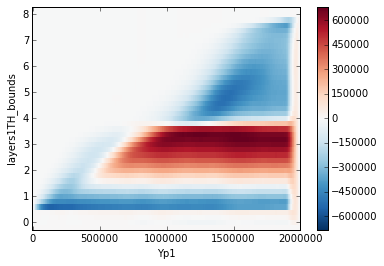

In [8]:
psi = -pad_array(gcm, 
        np.cumsum((ds.LaVH1TH.mean(dim=('time'))*ds.dxG).sum(dim='X'), axis=0),
        (0,None), dim='layers1TH_center', newdim='layers1TH_bounds')
# fix up the coordinate
psi.layers1TH_bounds.data = ds.layers1TH_bounds.data

psi.plot()

<xray.DataArray 'layers1TH_bounds' (layers1TH_bounds: 43)>
array([-0.2       ,  0.        ,  0.2       ,  0.40000001,  0.60000002,
        0.80000001,  1.        ,  1.20000005,  1.39999998,  1.60000002,
        1.79999995,  2.        ,  2.20000005,  2.4000001 ,  2.5999999 ,
        2.79999995,  3.        ,  3.20000005,  3.4000001 ,  3.5999999 ,
        3.79999995,  4.        ,  4.19999981,  4.4000001 ,  4.5999999 ,
        4.80000019,  5.        ,  5.19999981,  5.4000001 ,  5.5999999 ,
        5.80000019,  6.        ,  6.19999981,  6.4000001 ,  6.5999999 ,
        6.80000019,  7.        ,  7.19999981,  7.4000001 ,  7.5999999 ,
        7.80000019,  8.        ,  8.19999981], dtype=float32)
Coordinates:
    Yp1               >f4 1.875e+06
  * layers1TH_bounds  (layers1TH_bounds) >f4 -0.2 0.0 0.2 0.4 0.6 0.8 1.0 ...


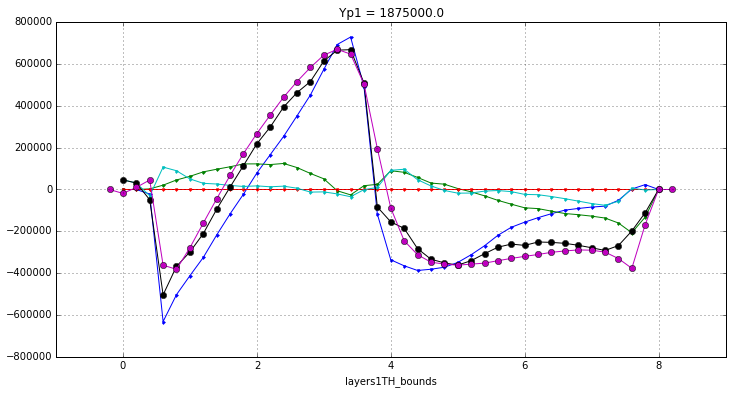

In [13]:
def plot_transformation(array, ax, jmax=25, **kwargs):
    omega = (array * ds.rA).mean(dim='time')[:,:-jmax].sum(dim=('X','Y'))
    omega.plot(ax=ax, **kwargs)

fig, ax = plt.subplots(figsize=(12,6))

plot_transformation(ds.LaTs1TH, ax, marker='.')
plot_transformation(ds.LaTz1TH, ax, marker='.')
plot_transformation(ds.LaTh1TH, ax, marker='.')
plot_transformation(-ds.w_numerical, ax, marker='.')

net = (ds.LaTs1TH + ds.LaTz1TH + ds.LaTh1TH - ds.w_numerical)
plot_transformation(net, ax, marker='o', color='k')

p = psi[:,-25]
p.plot(ax=ax, marker='o', color='m')

print p.layers1TH_bounds
plt.grid()

In [302]:
net

<xray.DataArray (time: 1, layers1TH_interface: 41, Y: 400, X: 200)>
dask.array<elemwis..., shape=(1, 41, 400, 200), dtype=float32, chunksize=(1, 41, 400, 200)>
Coordinates:
    YC                   (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rA                   (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    XC                   (Y, X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
    Depth                (Y, X) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * Y                    (Y) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * X                    (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * layers1TH_interface  (layers1TH_interface) >f4 0.0 0.2 0.4 0.6 0.8 1.0 ...
    iter                 (time) int64 2419200
  * time                 (time) int64 2177280000

In [239]:
def get_layer_depths(ds, dim, layers_name='1TH', point='s'):
    lprefix = 'layers' + layers_name
    thickness_varname = 'LaH' + point + layers_name
    mean_thickness = ds[thickness_varname].mean(dim=('time','X'))
    
    # this represents the depth of the layers1TH_bounds points
    # (used as the boundaries of the center values)
    zb = pad_array(gcm, 
        np.cumsum(mean_thickness[::-1], axis=0)[::-1],
        (None,0), dim=lprefix+'_center', newdim=lprefix+'_bounds')
    
    # and this is the depth of the layers1TH_center points
    # (used as the boundaries of the interface values)
    zc = interp_centered(gcm, zb)
    
    # the interface depths
    zi = zb[1:-1].rename({lprefix+'_bounds': lprefix+'_interface'})
    
    z= {lprefix + '_bounds': zb,
        lprefix + '_center': zc,
        lprefix + '_interface': zi}
    return z[dim]

def pcolor_layers(ds, array, ax=None, jmax=20, layers_name='1TH', **kwargs):

    lprefix = 'layers' + layers_name
    if array.dims[0] == lprefix + '_center':
        dim = lprefix + '_bounds'
    elif array.dims[0] == lprefix + '_interface':
        dim = lprefix + '_center'
    else:
        raise ValueError("Don't know how to pcolor coordinate %s" % array.dims[0])
    
    z = -get_layer_depths(ds, dim, layers_name).values[:,:-jmax+1]
    y = np.tile(ds.YG[:-jmax+1,0].values[np.newaxis,:], (z.shape[0],1))

    if ax is None:
        ax = plt.subplot(111)
    return ax.pcolormesh(y, z, array[:,:-jmax].values, **kwargs)
    
def contour_layers(ds, array, ax=None, jmax=20, layers_name='1TH', filled=True, **kwargs):

    z = -get_layer_depths(ds, array.dims[0]).values[:,:-jmax]
    y = np.tile(ds.YC[:-jmax,0].values[np.newaxis,:], (z.shape[0],1))
    
    if ax is None:
        ax = plt.subplot(111)
    if filled:
        return ax.contourf(y, z, array[:,:-jmax].values, **kwargs)
    else:
        return ax.contour(y, z, array[:,:-jmax].values, **kwargs)

In [240]:
def diapycnal_velocity_plot(ds, component, wlim=4e6, jmax=20):

    Tbar, _ = xray.broadcast(ds.layers1TH_interface, ds.Y)
    wvel = ds[component].mean(dim=('time','X'))

    psilevs = np.arange(-0.7,0.7,0.1)+0.05
    Tlevs = np.arange(-1,8,0.5)

    fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(12,5))

    (psi[:,:-jmax]/1e6).plot.contour(ax=ax0,
            levels=psilevs, colors='k', extend='both', add_colorbar=False)
    wvel[:,:-jmax].plot.pcolormesh(ax=ax0, cmap='RdBu_r',
            vmin=-wlim, vmax=wlim, add_colorbar=False)

    
    contour_layers(ds, psi/1e6, ax=ax1, jmax=jmax, filled=False,
               colors='k', levels=psilevs, extend='both')

    contour_layers(ds, Tbar, ax=ax1, jmax=jmax, filled=False,
               colors='c', levels=Tlevs)

    pc=pcolor_layers(ds, wvel, jmax=jmax ,ax=ax1, cmap='RdBu_r')
    pc.set_clim([-wlim, wlim])

    ax1.set_ylim([-2000,0])

In [241]:
ds

<xray.Dataset>
Dimensions:              (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layers1TH_bounds: 43, layers1TH_center: 42, layers1TH_interface: 41, time: 1)
Coordinates:
    YC                   (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG                   (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA                   (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
  * Xp1                  (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
    PHrefC               (Z) >f4 49.05 147.15 245.25 353.16 480.69 627.84 ...
    PHrefF               (Zp1) >f4 0.0 98.1 196.2 294.3 412.02 549.36 706.32 ...
    dxG                  (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
    dxC                  (Y, Xp1) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Yp1                  (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 ...
  * Zp1                  (

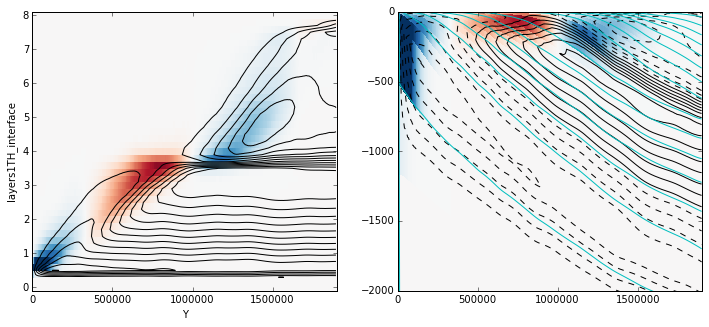

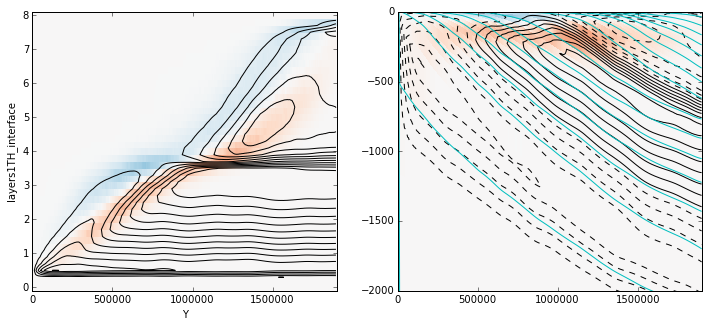

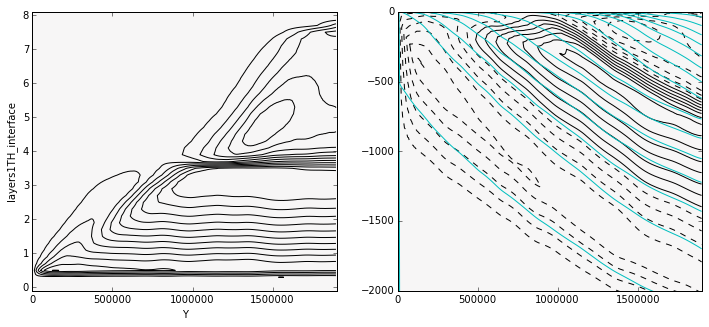

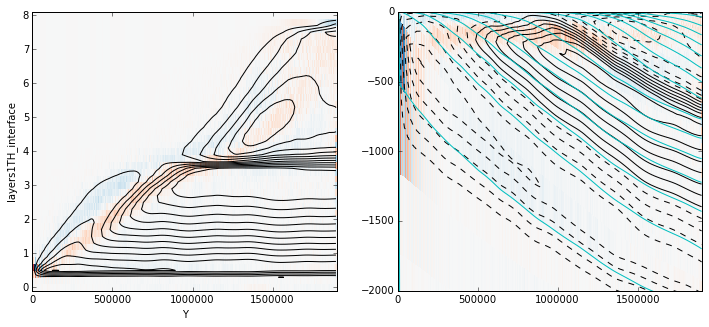

In [242]:
diapycnal_velocity_plot(ds, 'LaTs1TH', wlim=0.3e-5)
diapycnal_velocity_plot(ds, 'LaTz1TH', wlim=0.3e-5)
diapycnal_velocity_plot(ds, 'LaTh1TH', wlim=0.3e-5)
diapycnal_velocity_plot(ds, 'w_numerical', wlim=0.3e-5)

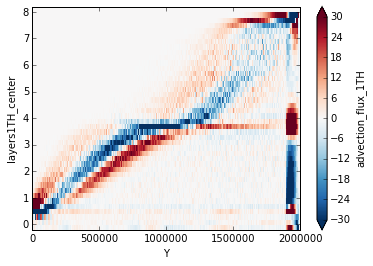

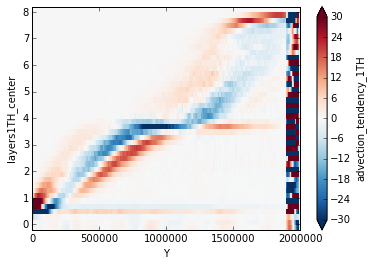

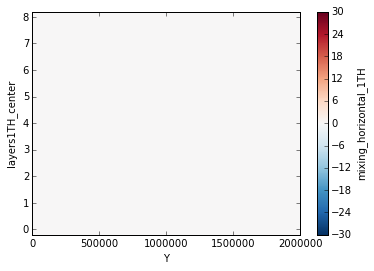

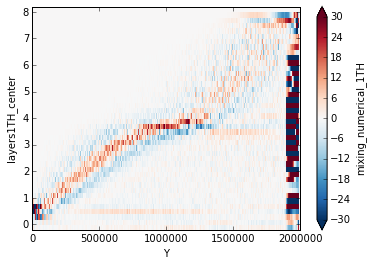

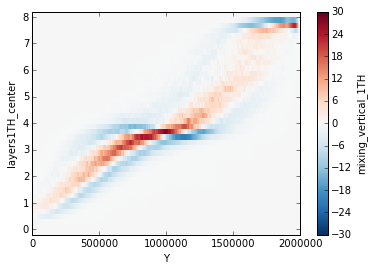

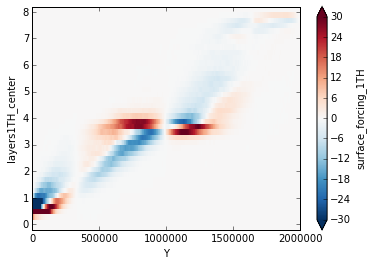

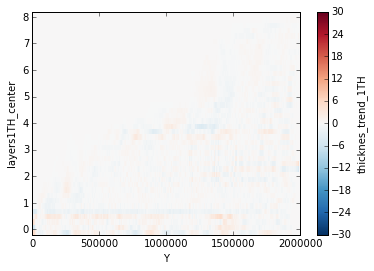

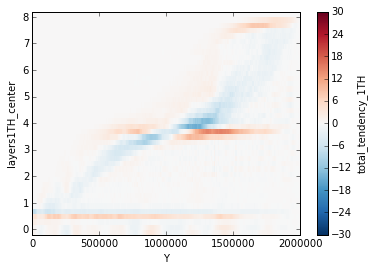

In [9]:
dvars = dsnew.data_vars.keys()
dvars.sort()
for k in dvars:
    plt.figure()
    dsnew[k].mean(dim=('time','X')).plot(vmin=-30, vmax=30, cmap='RdBu_r')

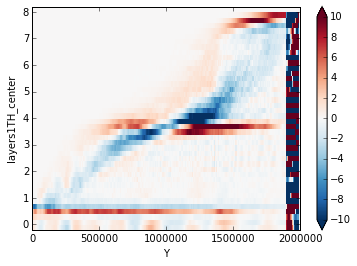

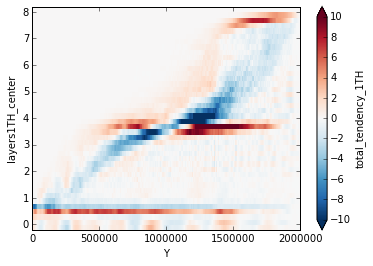

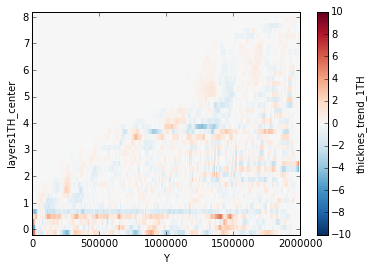

In [12]:
tottend_expected = (dsnew.advection_tendency_1TH + dsnew.mixing_vertical_1TH +
                    dsnew.mixing_horizontal_1TH + dsnew.surface_forcing_1TH)
plt.figure()
tottend_expected.mean(dim=('time','X')).plot(vmin=-10, vmax=10, cmap='RdBu_r')

plt.figure()
dsnew.total_tendency_1TH.mean(dim=('time','X')).plot(vmin=-10, vmax=10, cmap='RdBu_r')

plt.figure()
dsnew.thicknes_trend_1TH.mean(dim=('time','X')).plot(vmin=-10, vmax=10, cmap='RdBu_r')


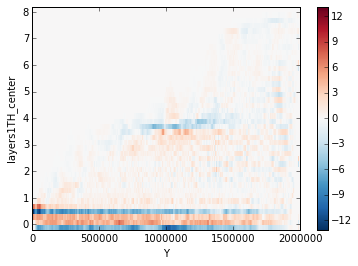

In [55]:
delta_hc = ds_trend.LaHc1TH.diff(dim='time', label='upper') / (np.diff(iters_trend)*deltaT)
(delta_hc * ds.rA).mean(dim=('time','X')).plot()


In [93]:
delta_hc

<xray.DataArray 'LaHc1TH' (time: 1, layers1TH_center: 42, Y: 400, X: 200)>
dask.array<elemwis..., shape=(1, 42, 400, 200), dtype=float64, chunksize=(1, 42, 400, 200)>
Coordinates:
    YC                (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rA                (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    XC                (Y, X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
    Depth             (Y, X) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * Y                 (Y) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * X                 (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * layers1TH_center  (layers1TH_center) float32 -0.1 0.1 0.3 0.5 0.7 0.9 ...
    iter              (time) int64 2073600
  * time              (time) int64 1866240000

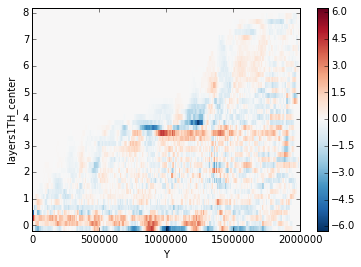

In [21]:
delta_hc = ds_trend.LaHc1TH.diff(dim='time', label='upper') / (np.diff(iters_trend)*deltaT)
(delta_hc * ds.rA).mean(dim=('time','X')).plot()

In [57]:
sum(ds.LaVH1TH)

<xray.DataArray 'LaVH1TH' (layers1TH_center: 42, Yp1: 400, X: 200)>
dask.array<elemwis..., shape=(42, 400, 200), dtype=float32, chunksize=(42, 400, 200)>
Coordinates:
    dxG               (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * Yp1               (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * X                 (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 ...
    rAs               (Yp1, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    dyC               (Yp1, X) >f4 5000.0 5000.0 5000.0 5000.0 5000.0 5000.0 ...
  * layers1TH_center  (layers1TH_center) float32 -0.1 0.1 0.3 0.5 0.7 0.9 ...
    iter              int64 2419200
    time              int64 2177280000

In [5]:
diff_vh = gcm.diff_yp1_to_y(ds.LaVH1TH * ds.dxG)
diff_uh = gcm.diff_xp1_to_x(ds.LaUH1TH * ds.dyG)

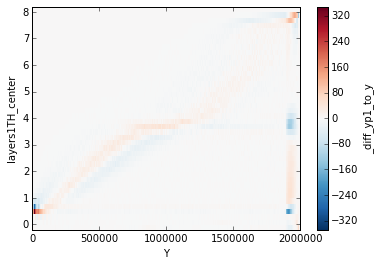

In [6]:
diff_vh.mean(dim=('time', 'X')).plot()

In [78]:
ws = pad_array(gcm, ds.LaTs1TH * ds.rA)
dws = diff_centered(gcm, ws)

wz = pad_array(gcm, ds.LaTz1TH * ds.rA)
dwz = diff_centered(gcm, wz)

# advection (from tendency)
wa = pad_array(gcm, (ds.LTha1TH + ds.LTza1TH) * ds.rA)
dwa = diff_centered(gcm, wa)

# advection (from flux)
dvh = -gcm.diff_yp1_to_y(ds.LaVH1TH * ds.dxG)

# difference = numerical diffusion
dnum = -dvh + dwa


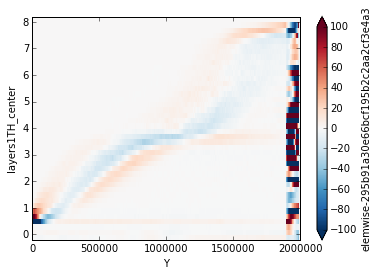

In [50]:
dwa.mean(dim=('time', 'X')).plot(vmin=-100, vmax=100, cmap='RdBu_r')

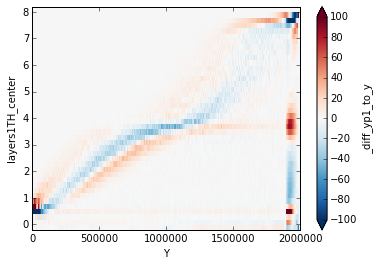

In [51]:
dvh.mean(dim=('time', 'X')).plot(vmin=-100, vmax=100, cmap='RdBu_r')

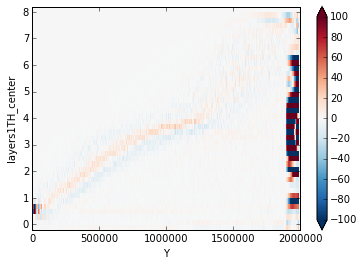

In [52]:
dnum.mean(dim=('time', 'X')).plot(vmin=-100, vmax=100, cmap='RdBu_r')

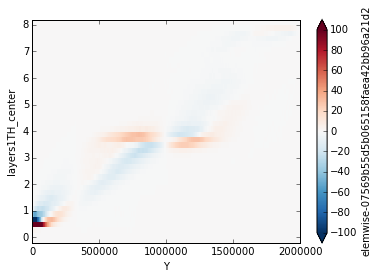

In [93]:
dws.mean(dim=('time', 'X')).plot(vmin=-100, vmax=100, cmap='RdBu_r')

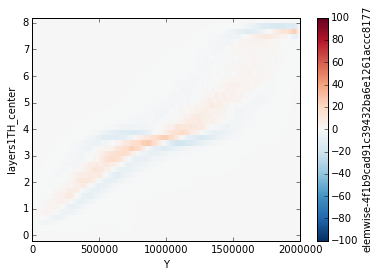

In [94]:
dwz.mean(dim=('time', 'X')).plot(vmin=-100, vmax=100, cmap='RdBu_r')

In [6]:
# convergence from mass transport
vh = (ds.LaVH1TH * ds.dxG).mean(dim=('time','X')) 
diff_vh = np.diff(vh.values, axis=vh.get_axis_num('Yp1'))

wh = ((ds.LaTz1TH + ds.LaTs1TH)*ds.rA).mean(dim=('time','X')) 
diff_wh = np.diff(wh.values, axis=wh.get_axis_num('layers1TH_interface'))

<matplotlib.colorbar.Colorbar instance at 0x7f2d3f581290>

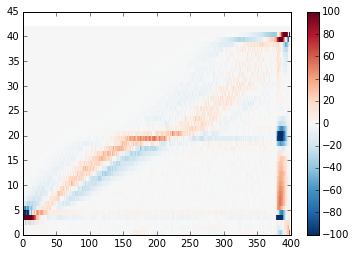

In [7]:
plt.pcolormesh(diff_vh, cmap='RdBu_r')
plt.clim([-100,100])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2d3f348830>

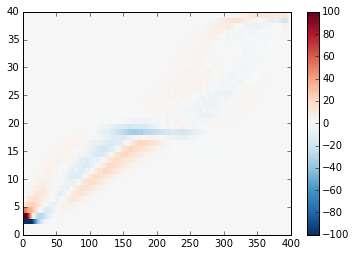

In [8]:
plt.pcolormesh(diff_wh, cmap='RdBu_r')
plt.clim([-100,100])
plt.colorbar()

In [9]:
print diff_vh.shape
print diff_wh.shape

(42, 399)
(40, 400)


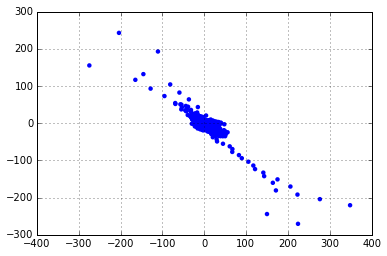

In [10]:
plt.scatter(diff_vh[1:-1,:-40], diff_wh[:,:-41], edgecolor='none')
plt.grid()

<matplotlib.colorbar.Colorbar instance at 0x7fbaafea72d8>

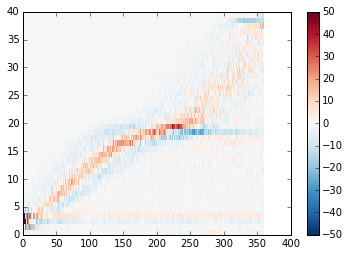

In [24]:
plt.pcolormesh(diff_vh[1:-1,:-40] + diff_wh[:,:-41], cmap='RdBu_r')
plt.clim([-50,50])
plt.colorbar()

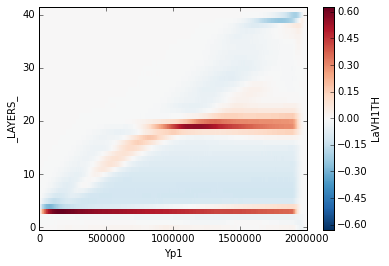

In [7]:
ds.LaVH1TH.mean(dim=('time','X')).plot()

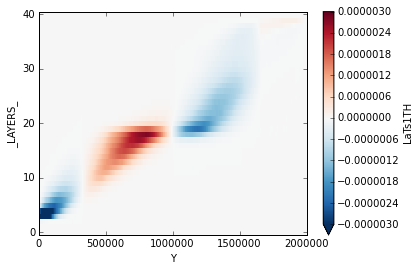

In [22]:
ds.LaTs1TH.mean(dim=('time','X')).plot(vmin=-3e-6, vmax=3e-6)

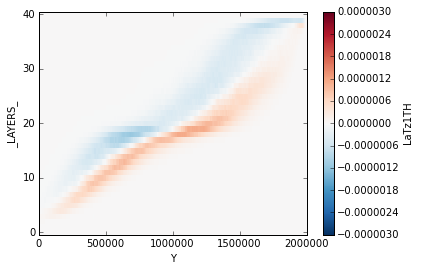

In [23]:
ds.LaTz1TH.mean(dim=('time','X')).plot(vmin=-3e-6, vmax=3e-6)

In [7]:
ds.LTha1TH.diff(dim='Y')

<xray.DataArray 'LTha1TH' (time: 1, layers1TH_interface: 41, Y: 399, X: 200)>
dask.array<elemwis..., shape=(1, 41, 399, 200), dtype=float32, chunksize=(1, 41, 399, 200)>
Coordinates:
    YC                   (Y, X) >f4 7500.0 7500.0 7500.0 7500.0 7500.0 ...
    rA                   (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    XC                   (Y, X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
    Depth                (Y, X) >f4 2985.0 2985.0 2985.0 2985.0 2985.0 ...
  * Y                    (Y) >f4 7500.0 12500.0 17500.0 22500.0 27500.0 ...
  * X                    (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * layers1TH_interface  (layers1TH_interface) >f4 0.0 0.2 0.4 0.6 0.8 1.0 ...
    iter                 (time) int64 2073600
  * time                 (time) int64 1866240000

In [4]:
xray.__version__

'0.6.1'

In [5]:
xray

<module 'xray' from '/home/rpa/xray/xray/__init__.py'>

In [52]:
Ny, Nx = (10,20)
dims = ('Y','X')


# can I reproduce the weird problem
data = da.random.random((Ny,Nx), chunks=(Ny,Nx))
array = xray.DataArray(data, dims=dims)
array

<xray.DataArray 'da.random.random_sample-5a26f08dbcd8dfff9bd6e6cb1ad370fa' (Y: 10, X: 20)>
dask.array<da.rand..., shape=(10, 20), dtype=float64, chunksize=(10, 20)>
Coordinates:
  * Y        (Y) int64 0 1 2 3 4 5 6 7 8 9
  * X        (X) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [56]:
zarr = da.zeros((1,Nx), dtype=array.dtype, chunks=(1,Nx))
zeros_bot = xray.DataArray(zarr, {'Y':np.atleast_1d(-1)}, dims)
zeros_top = xray.DataArray(zarr, {'Y':np.atleast_1d(Ny)}, dims)

In [59]:
b = xray.concat([zeros_bot, array, zeros_top], dim='Y')

In [60]:
b

<xray.DataArray 'wrapped-61f783ed90d1f6c77ae355aca3dbe48d' (Y: 12, X: 20)>
dask.array<concate..., shape=(12, 20), dtype=float64, chunksize=(1, 20)>
Coordinates:
  * X        (X) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * Y        (Y) int64 -1 0 1 2 3 4 5 6 7 8 9 10

In [61]:
b.values

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.93965027,  0.55112266,  0.72070789,  0.91961883,  0.7368914 ,
         0.8737436 ,  0.93473094,  0.00545012,  0.04315137,  0.11872135,
         0.34007173,  0.81583489,  0.42523872,  0.81414378,  0.39785639,
         0.05886571,  0.04845431,  0.02416916,  0.15914426,  0.80038611],
       [ 0.93850257,  0.75337401,  0.01809139,  0.97030222,  0.09235292,
         0.93294244,  0.46327921,  0.81616553,  0.62970509,  0.95072738,
         0.20467024,  0.41788859,  0.86690841,  0.53863547,  0.55114415,
         0.3504188 ,  0.79907269,  0.36199569,  0.85686313,  0.14206269],
       [ 0.43087373,  0.42918692,  0.04716885,  0.34382987,  0.52878239,
         0.05845437,  0.4709982 ,  0.917746  ,  

In [58]:
xray.auto_combine?

In [59]:
dnew = xray.Dataset()

In [60]:
dnew

<xray.Dataset>
Dimensions:  ()
Coordinates:
    *empty*
Data variables:
    *empty*